Original dataset shape: (30000, 24)

Validation Set Performance:
Mean Absolute Error (MAE): 21502.02
Mean Squared Error (MSE): 948975515.96
R² Score: 0.56

Test Set Performance:
Mean Absolute Error (MAE): 21683.95
Mean Squared Error (MSE): 969390282.45
R² Score: 0.58


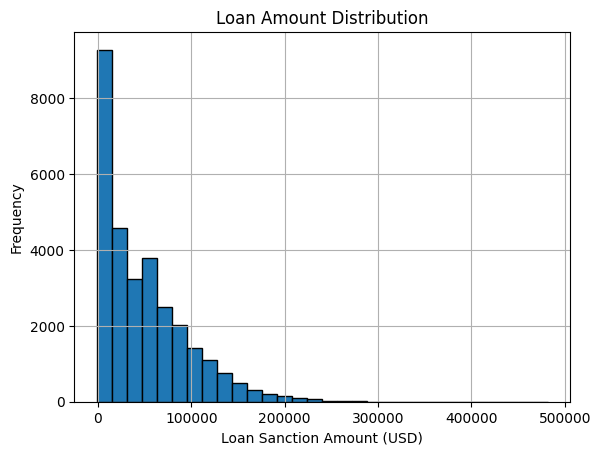

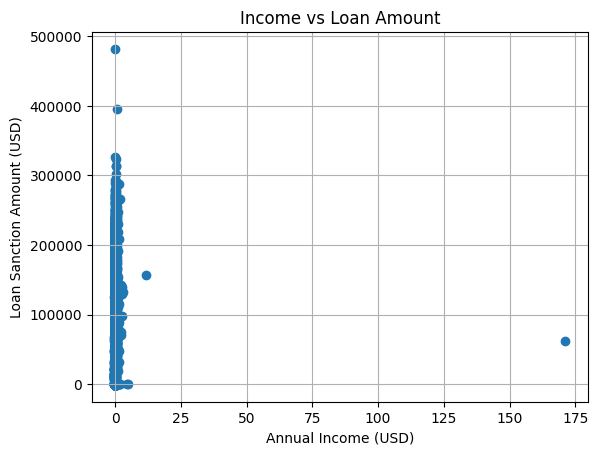

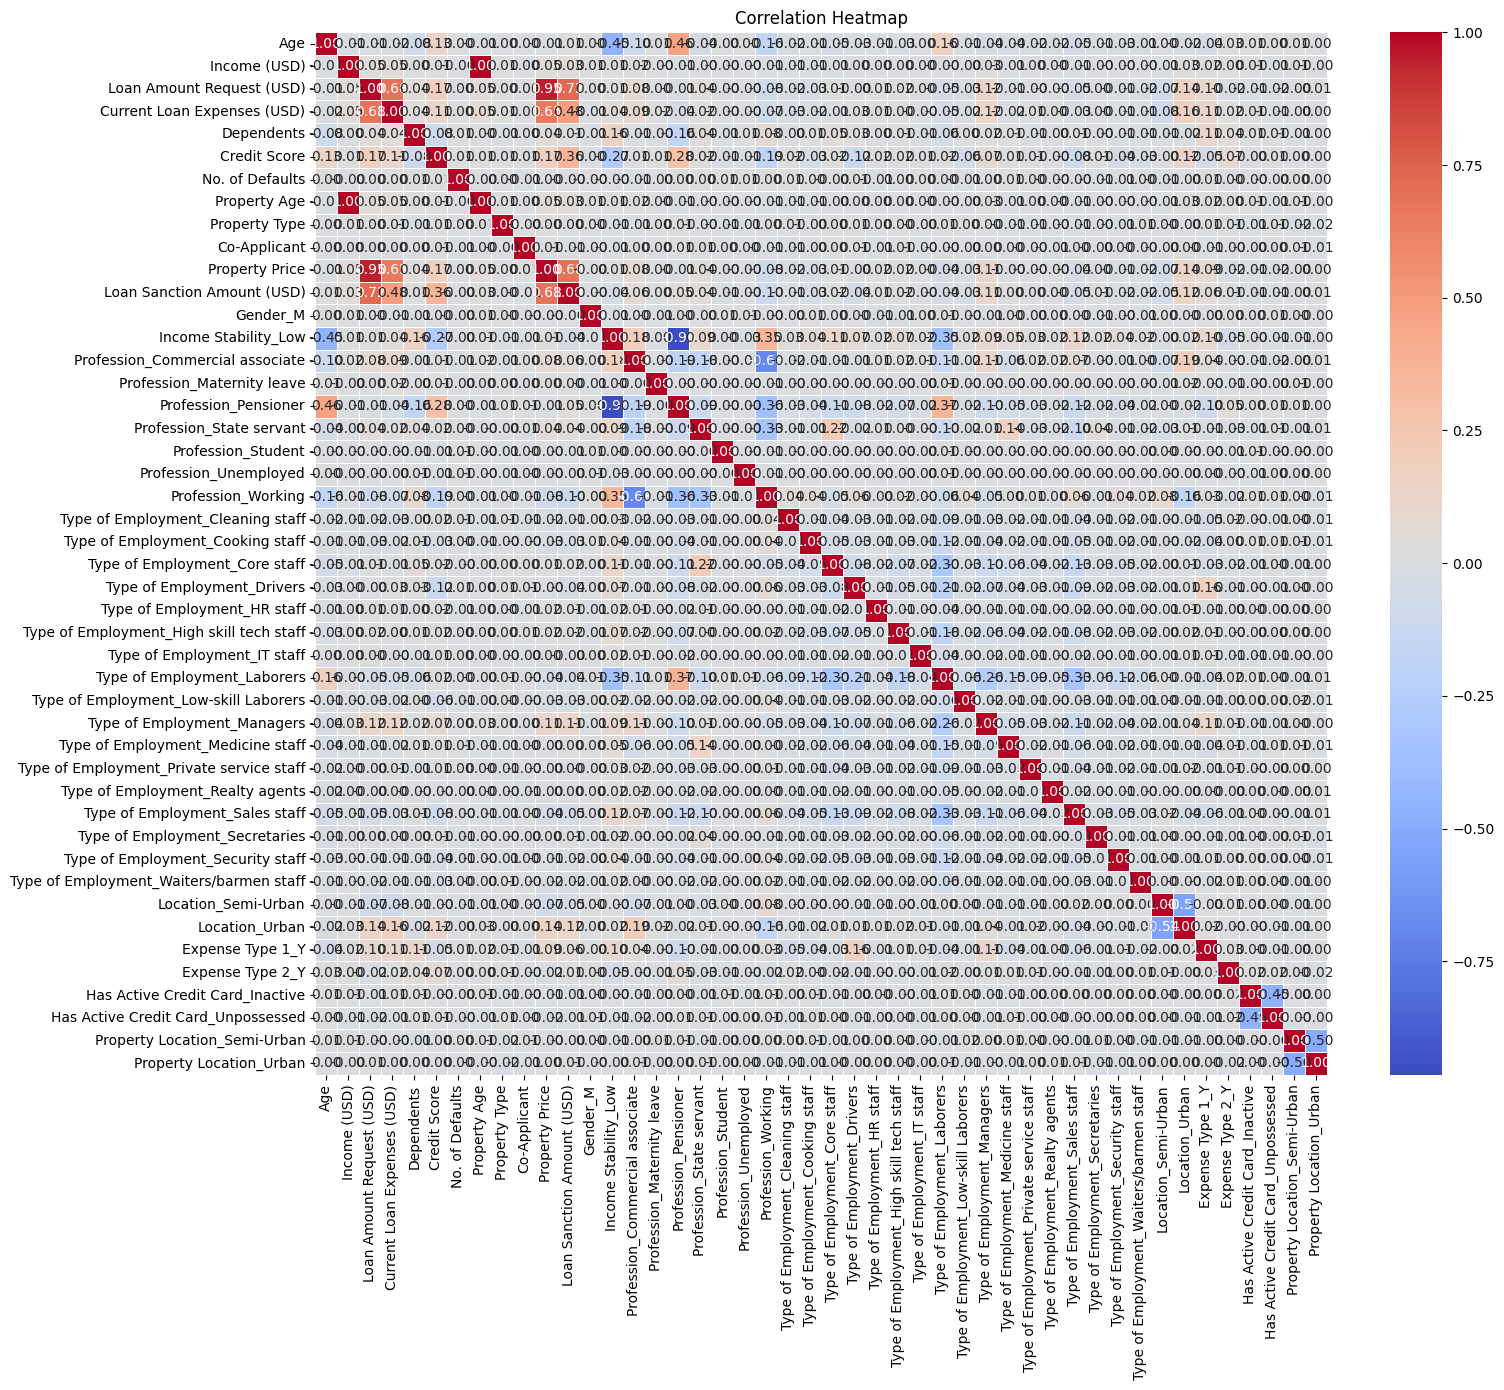

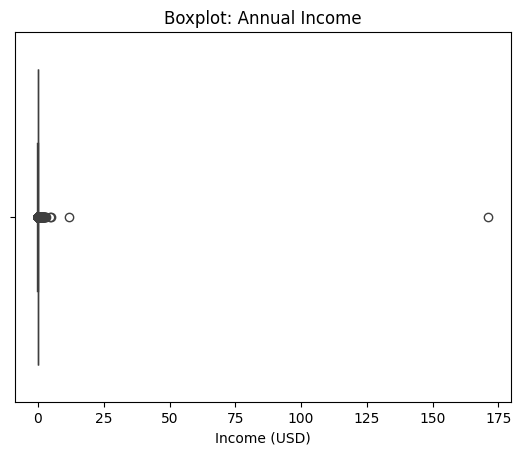

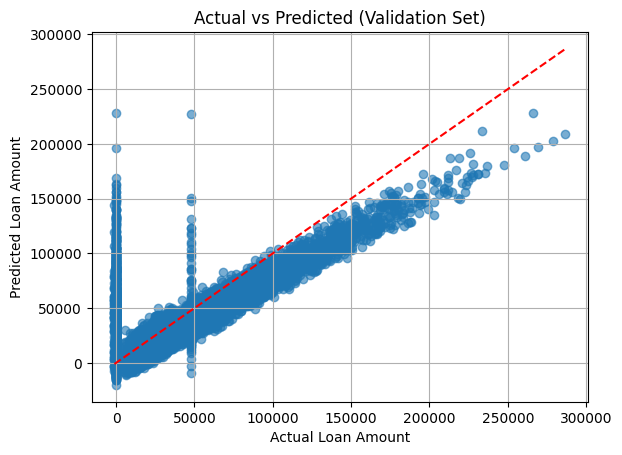

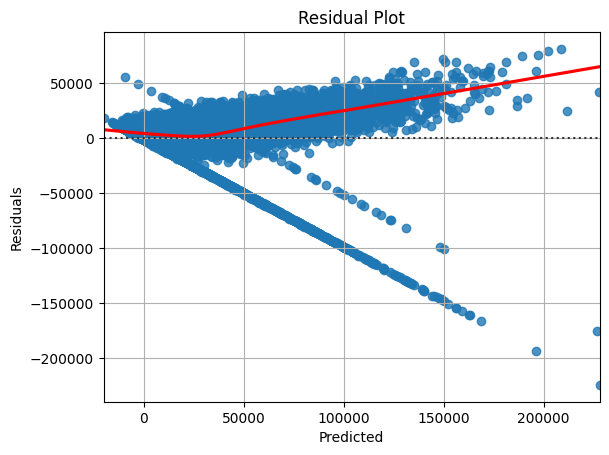

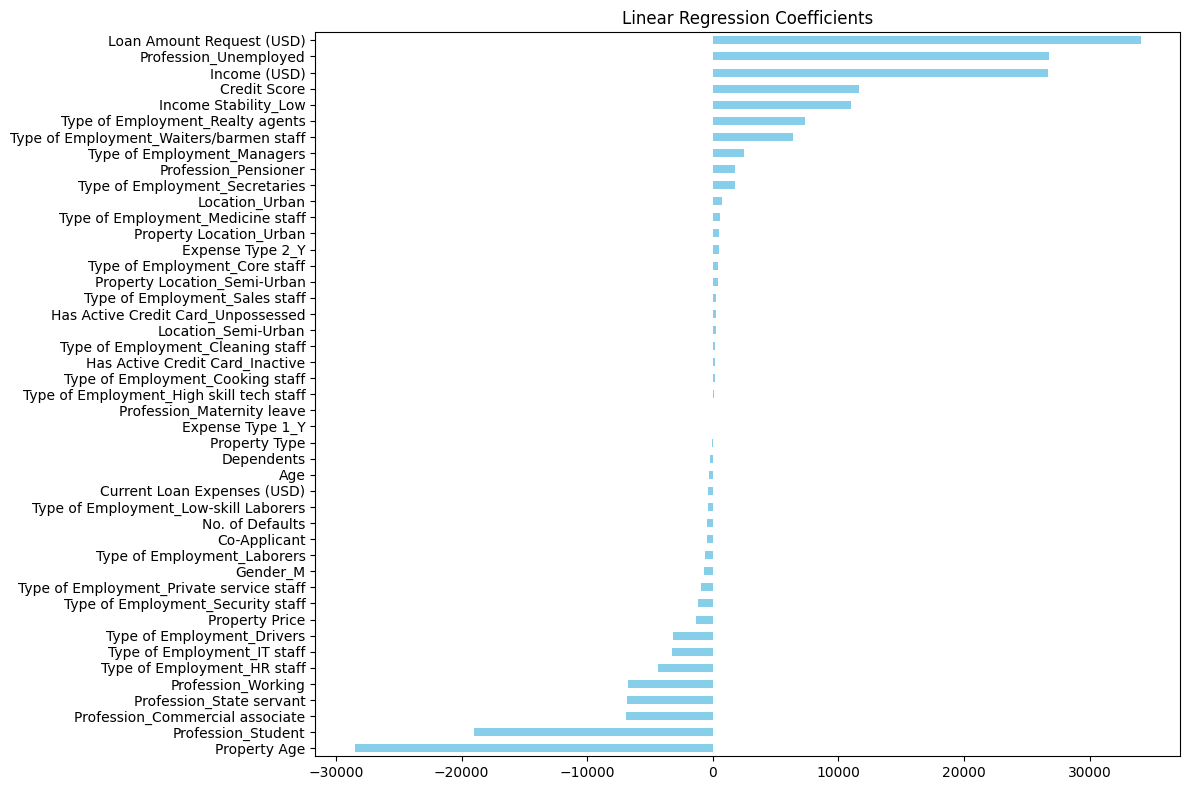

In [2]:
# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 2. Load the dataset
df = pd.read_csv('train.csv')
print("Original dataset shape:", df.shape)

# 3. Preprocessing function (without scaling target)
def preprocess(df, target=None):
    df = df.copy()

    # Drop unnecessary identifier columns
    drop_cols = ['Customer ID', 'Name', 'Property ID']
    for col in drop_cols:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

    # Fill missing numeric values with mean
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(df[col].mean())

    # Fill missing categorical values with mode
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    # One-hot encoding for categoricals
    df = pd.get_dummies(df, drop_first=True)

    # Scale numeric features EXCEPT target
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include='number').columns
    if target and target in num_cols:
        num_cols = num_cols.drop(target)
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

# 4. Apply preprocessing
target_col = 'Loan Sanction Amount (USD)'
df = preprocess(df, target=target_col)

# 5. Split into features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# 6. Split the data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 7. Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# 9. Evaluation Metrics
print("\nValidation Set Performance:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.2f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.2f}")

print("\nTest Set Performance:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_test_pred):.2f}")

# 10. EDA Visualizations
# Histogram of Target
plt.hist(y, bins=30, edgecolor='black')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Sanction Amount (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Scatter Plot
plt.scatter(X['Income (USD)'], y)
plt.xlabel("Annual Income (USD)")
plt.ylabel("Loan Sanction Amount (USD)")
plt.title("Income vs Loan Amount")
plt.grid(True)
plt.show()

# Correlation Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Boxplot for Income
sns.boxplot(x=X['Income (USD)'])
plt.title("Boxplot: Annual Income")
plt.show()

# 11. Evaluation Visuals
# Actual vs Predicted Plot (Validation)
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_val - y_val_pred
sns.residplot(x=y_val_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Coefficient Plot
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values().plot(kind='barh', figsize=(12, 8), color='skyblue')
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()
